# Algoritmo de Entrenamiento de RNN (LSTM) de Detección de Emociones

El algoritmo implementa un modelo LSTM bidireccional con embeddings preentrenados (fastText) para detectar emociones en textos en español. Usa una arquitectura típica de NLP moderna:

* Tokenización y embeddings para representar texto.

* Modelo LSTM para capturar dependencias secuenciales.

* Clasificación multiclase con softmax para asignar una emoción.



# Detalles paso a paso
##  Preprocesamiento del texto

1. Convierte texto a minúsculas.

2- Elimina tildes y signos de puntuación.

3- Remueve URLs, menciones y hashtags.

4. Elimina caracteres no alfabéticos.

Esto estandariza el texto para mejorar la consistencia durante la tokenización y el modelado.

## Traducción de etiquetas emocionales

1. Las emociones en inglés se traducen a español.

2. Se utiliza LabelEncoder y luego to_categorical para convertirlas a vectores one-hot.



In [1]:
# 🚀 1. Importar librerías necesarias
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, Bidirectional # Añadido Bidirectional
# from tensorflow.keras import regularizers # No se usa L2 ahora
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
# from sklearn.utils.class_weight import compute_class_weight # No se usa

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import re
import unicodedata
import matplotlib.pyplot as plt
import os
import pickle
import gzip
import subprocess

# Descargar los embeddings fastText en español

Los embeddings preentrenados como FastText permiten que el modelo comience con un conocimiento lingüístico previo en español, sin tener que aprender desde cero la relación entre palabras.

# Uso de embeddings preentrenados (fastText)

* Se carga cc.es.300.vec.gz, embeddings en español de fastText (300 dimensiones).

* Se crea una matriz de embeddings alineada al vocabulario del tokenizer.

* Las palabras no encontradas usan un vector nulo (0s).

Esta matriz se usa como peso inicial de la capa Embedding. Al principio está congelada (no entrenable) y luego se descongela (fine-tuning).



Esto mejora la precisión y acelera el entrenamiento.



In [2]:
# 1b. Descargar los embeddings fastText en español (ACTIVADO)

#embed_path: ruta local donde se almacenarán los embeddings.

#embed_url: URL oficial de los vectores FastText en español.

#PRETRAINED_EMBEDDING_DIM: dimensión de cada vector (300).


embed_path = '/content/cc.es.300.vec.gz'
embed_url = 'https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.vec.gz'
PRETRAINED_EMBEDDING_DIM = 300



if not os.path.exists(embed_path):
    print(f"Descargando embeddings fastText desde {embed_url}...")
    try:
        result = subprocess.run(['wget', '-O', embed_path, embed_url], check=True, capture_output=True, text=True)
        print("Descarga completada.")
    except Exception as e:
        print(f"Error al descargar embeddings: {e}")
        embed_path = None # Fallback
else:
   print(f"Embeddings fastText ya existen en {embed_path}.")

if embed_path is None or not os.path.exists(embed_path):
  embed_path = None

if embed_path: print("Embeddings pre-entrenados ACTIVADOS.")

else: print("Embeddings pre-entrenados DESACTIVADOS."); exit() # Salir si no hay embeddings

Descargando embeddings fastText desde https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.vec.gz...
Descarga completada.
Embeddings pre-entrenados ACTIVADOS.


In [3]:
# 1c. Cargar embeddings fastText (ACTIVADO)
embeddings_index = {}  # Diccionario donde se almacenarán los embeddings
num_loaded = 0         # Contador de vectores cargados


if embed_path and os.path.exists(embed_path):
    print(f"Cargando embeddings desde {embed_path}...")
    try:
        with gzip.open(embed_path, 'rt', encoding='utf-8', newline='\n', errors='ignore') as f:
            header = f.readline().split(); print(f"Cabecera: {header}")
            for line in f:
                values = line.rstrip().split(' ')
                word = values[0]
                if len(values) == PRETRAINED_EMBEDDING_DIM + 1:
                   try:
                       coefs = np.asarray(values[1:], dtype='float32')
                       embeddings_index[word] = coefs; num_loaded += 1
                   except ValueError: pass
    except Exception as e: print(f"Error al leer embeddings: {e}"); embeddings_index = {}
    print(f'Se cargaron {num_loaded} vectores.')
    if not embeddings_index: print("ADVERTENCIA: Falló carga de embeddings."); exit() # Salir si falló
else: print("Archivo de embeddings no encontrado."); exit() # Salir si no hay archivo



Cargando embeddings desde /content/cc.es.300.vec.gz...
Cabecera: ['2000000', '300']
Se cargaron 2000000 vectores.


In [4]:
embeddings_index

{'de': array([ 5.470e-02,  1.120e-02,  1.910e-01,  3.080e-02,  4.140e-02,
         3.030e-02, -8.790e-02, -5.270e-02,  1.580e-02, -8.570e-02,
        -1.319e-01, -2.033e-01, -2.720e-02,  4.700e-03,  1.056e-01,
         5.100e-03, -8.900e-02, -3.369e-01, -2.980e-02, -3.660e-02,
         3.560e-02,  2.750e-02, -2.423e-01,  1.990e-01,  3.150e-02,
        -1.087e-01,  4.592e-01,  3.190e-02, -1.572e-01,  2.120e-02,
         5.000e-03, -2.310e-02,  4.200e-02, -4.400e-03,  4.680e-02,
        -5.530e-02, -8.300e-03, -6.300e-03,  1.856e-01, -2.140e-02,
        -6.590e-02,  1.750e-01,  4.530e-01,  2.750e-02,  5.390e-02,
         5.310e-02,  1.336e-01,  2.420e-02, -1.440e-02, -7.460e-02,
         3.630e-02,  3.120e-02, -1.961e-01,  3.240e-02, -2.140e-02,
        -1.861e-01,  1.260e-02, -4.090e-02, -5.020e-02, -3.150e-02,
         4.750e-02,  1.400e-02,  1.860e-02, -3.580e-02,  4.640e-02,
         7.480e-02, -7.250e-02, -7.420e-02, -6.100e-03, -1.204e-01,
         1.031e-01,  4.000e-04, -4.740e-02

In [5]:
# 2. Configurar uso de GPU si está disponible
# Consulta cuántas GPUs físicas tiene el entorno (por ejemplo, Google Colab ofrece 1 GPU si está habilitada).

gpus = tf.config.list_physical_devices('GPU')

#Activa set_memory_growth para evitar errores
#Esto le dice a TensorFlow que no ocupe toda la memoria de la GPU desde el inicio, sino que la vaya ocupando según la necesite.
#Es útil en Colab y evita errores como CUDNN_STATUS_ALLOC_FAILED.


if gpus:
  try:
    for gpu in gpus: tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e: print(e)
else: print("No se detectó GPU, se usará CPU.")

1 Physical GPUs, 1 Logical GPUs


# Cargar datos desde una URL remota


In [6]:
# 3. Cargar tus datos
try:
  df = pd.read_csv('https://raw.githubusercontent.com/adiacla/sentimientos/refs/heads/main/emociones.csv', sep="|")
  print("Datos cargados:"); print(df.head()); print(f"\nForma inicial: {df.shape}")
except Exception as e: print(f"Error al cargar CSV: {e}"); exit()

Datos cargados:
                                               tweet    emotion
0   Solo soy un desastre caliente que está estres...  depressed
1   Estoy tan aburrido de esta mierda de nuevo. E...  depressed
2   Me encantaban tus cosas viejas, pero esto, es...  depressed
3   alguna vez se deprimen, porque la única perso...  depressed
4   En realidad, liau es un signo de madurez, cre...  depressed

Forma inicial: (40806, 2)


#Traducción de las etiquetas

El objetivo es traducir las etiquetas de emociones que están originalmente en inglés a su equivalente en español.

Para lograr esto, se construye un diccionario llamado emotion_translation que actúa como tabla de correspondencia entre las emociones en inglés (por ejemplo, 'depressed', 'anger', 'neutral') y sus traducciones al español (por ejemplo, 'deprimido', 'enojo', 'neutral').

Luego, el DataFrame df —que contiene una columna llamada 'emotion' con etiquetas en inglés— es enriquecido con una nueva columna llamada 'emotion_es'. Esta nueva columna contiene las emociones ya traducidas al español, aplicando el diccionario mediante la función map(), que reemplaza cada etiqueta original con su traducción correspondiente.

In [7]:
# 4. Preprocesamiento y Limpieza de Texto

emotion_translation = {
 'depressed': 'deprimido', 'hopeless': 'desesperanzado', 'lonely': 'solitario', 'suicidal': 'suicida',
 'disappointment': 'decepción', 'disgust': 'asco', 'remorse': 'remordimiento', 'grief': 'duelo',
 'embarrassment': 'vergüenza', 'fear': 'miedo', 'nervousness': 'nerviosismo', 'sadness': 'tristeza',
 'anger': 'enojo', 'neutral': 'neutral'
}
df['emotion_es'] = df['emotion'].map(emotion_translation)
print("\nEmociones traducidas:"); print(df['emotion_es'].value_counts())



Emociones traducidas:
emotion_es
neutral           6995
suicida           6830
deprimido         5949
solitario         5023
decepción         4765
asco              2289
miedo             2235
enojo             1388
tristeza          1201
desesperanzado    1180
vergüenza         1094
remordimiento      956
nerviosismo        611
duelo              290
Name: count, dtype: int64


In [8]:
def clean_text(text):
  if not isinstance(text, str): return ""
  text = text.lower()
  text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode('utf-8')
  text = re.sub(r"http\S+", "", text); text = re.sub(r"@\w+", "", text)
  text = re.sub(r"#\w+", "", text); text = re.sub(r"[^a-zA-Z\s]", "", text)
  text = re.sub(r'\s+', ' ', text).strip(); return text
df['tweet_clean'] = df['tweet'].apply(clean_text)
print("\nTweets limpios (head):"); print(df[['tweet_clean']].head())
df = df.dropna(subset=['tweet_clean', 'emotion_es'])
df = df[df['tweet_clean'].str.strip() != '']; print(f"\nForma tras limpieza: {df.shape}")


Tweets limpios (head):
                                         tweet_clean
0  solo soy un desastre caliente que esta estresa...
1  estoy tan aburrido de esta mierda de nuevo est...
2  me encantaban tus cosas viejas pero esto esto ...
3  alguna vez se deprimen porque la unica persona...
4  en realidad liau es un signo de madurez creo p...

Forma tras limpieza: (40797, 4)


In [9]:
df['emotion_es'].unique()

array(['deprimido', 'desesperanzado', 'solitario', 'suicida', 'decepción',
       'asco', 'remordimiento', 'duelo', 'vergüenza', 'miedo',
       'nerviosismo', 'tristeza', 'enojo', 'neutral'], dtype=object)

# tokenizar

Tokenizar significa dividir un texto en unidades más pequeñas llamadas “tokens”. En procesamiento de lenguaje natural (NLP), los tokens suelen ser:

* Palabras individuales (tokenización por palabra).

* Subpalabras o sílabas (tokenización subword, como en BERT).

* Caracteres (tokenización a nivel de caracter, menos común para análisis de texto completo).


## Objetivo de tokenizar
Convertir texto en una forma procesable por modelos de machine learning, especialmente redes neuronales.

Transformar palabras en índices numéricos, ya que los modelos no pueden procesar directamente texto plano.

Construir un vocabulario que asigne un número a cada palabra conocida.

Permitir que los modelos aprendan relaciones estadísticas entre las palabras (tokens) en vez del texto completo.

## tokenización en este proyecto?

En este proyecto de análisis de sentimientos o emociones en textos (en este caso, tweets), la tokenización:

* Prepara los textos (tweet_clean) para ser usados en una red neuronal o modelo de aprendizaje automático.

* Convierte cada frase o tweet limpio en una secuencia de enteros que representan las palabras.

* Se encarga de tratar palabras desconocidas usando un token especial <OOV> (“Out Of Vocabulary”) para palabras que no están en el vocabulario aprendido.

Esto es esencial para alimentar una red neuronal, ya que los textos deben estar representados como vectores numéricos.

## Ejemplo
Supongamos que el tweet limpio es:

**"me siento deprimido"**

Y el vocabulario que se construyó es:

**{'me': 1, 'siento': 2, 'deprimido': 3}**

El texto se convertirá en la secuencia:
**[1, 2, 3]**


In [10]:
# 5. Tokenizar los textos

#Se crea un tokenizador de Keras con un token especial para palabras desconocidas (<OOV>).

oov_token = '<OOV>'; tokenizer = Tokenizer(oov_token=oov_token)
tokenizer.fit_on_texts(df['tweet_clean'].values); word_index = tokenizer.word_index
vocab_size = len(word_index) + 1; print(f"\nTamaño del vocabulario: {vocab_size}")

#Se entrena el tokenizador con el texto limpio del DataFrame (tweet_clean). Esto crea el vocabulario, asignando un número único a cada palabra encontrada.

sequences = tokenizer.texts_to_sequences(df['tweet_clean'].values)


Tamaño del vocabulario: 54427


In [11]:
sequences[:2]

[[20,
  85,
  11,
  931,
  1273,
  3,
  26,
  4057,
  147,
  119,
  11449,
  21,
  7118,
  1603,
  3,
  343,
  2954,
  4,
  75,
  31,
  94,
  1224,
  22,
  12,
  42,
  25,
  17,
  8729],
 [28,
  35,
  486,
  2,
  26,
  91,
  2,
  192,
  28,
  35,
  168,
  2,
  239,
  2383,
  111,
  91,
  2,
  2168,
  2,
  328,
  3,
  118,
  294,
  23,
  2319,
  657,
  47,
  15,
  1261,
  25091,
  13776,
  3,
  99,
  2256,
  252,
  798,
  14,
  45,
  7119]]

#Padding

Relleno o padding, y tiene como objetivo preparar las secuencias para su uso en modelos de deep learning, donde todas deben tener la misma longitud.

In [12]:
#  6. Padding de secuencias
#Este bloque realiza el relleno (padding) y recorte (truncating) de las secuencias de texto que ya han sido tokenizadas, para que todas tengan la misma longitud: en este caso, 50 tokens.

maxlen = 50; X = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')
print(f"\nForma de X tras padding: {X.shape}")


Forma de X tras padding: (40797, 50)


#Codificar el label

Codificar las etiquetas de salida (emociones) para que puedan ser utilizadas por un modelo de clasificación supervisada, como una red neuronal.

Convierte las etiquetas categóricas de emociones (por ejemplo, 'tristeza', 'enojo', 'neutral') en una representación numérica, y luego en una codificación one-hot, que es el formato requerido por muchos modelos de clasificación multiclase.


Los modelos de machine learning no pueden trabajar directamente con texto como etiquetas de salida.

Es necesario traducir esas emociones a números enteros únicos (por ejemplo, 'tristeza' → 3).

Luego se transforman a vectores one-hot (por ejemplo, 'tristeza' → [0, 0, 0, 1, 0, ...]) para:

Representar la clase en un formato entendible por redes neuronales.

Permitir que el modelo use funciones de pérdida como categorical_crossentropy.

In [13]:
# 7. Codificar las etiquetas

label_encoder = LabelEncoder(); integer_encoded = label_encoder.fit_transform(df['emotion_es'].values)
num_classes = len(label_encoder.classes_); print(f'\nNum clases: {num_classes}'); print(f'Clases: {label_encoder.classes_}')
y = to_categorical(integer_encoded, num_classes=num_classes); print(f"Forma de y (one-hot): {y.shape}")


Num clases: 14
Clases: ['asco' 'decepción' 'deprimido' 'desesperanzado' 'duelo' 'enojo' 'miedo'
 'nerviosismo' 'neutral' 'remordimiento' 'solitario' 'suicida' 'tristeza'
 'vergüenza']
Forma de y (one-hot): (40797, 14)


In [14]:
label_encoder.classes_

array(['asco', 'decepción', 'deprimido', 'desesperanzado', 'duelo',
       'enojo', 'miedo', 'nerviosismo', 'neutral', 'remordimiento',
       'solitario', 'suicida', 'tristeza', 'vergüenza'], dtype=object)

In [15]:
y[:2]

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [16]:
# 8. Dividir datos en entrenamiento y validación

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nForma train: {X_train.shape}, {y_train.shape}"); print(f"Forma val: {X_val.shape}, {y_val.shape}")


Forma train: (32637, 50), (32637, 14)
Forma val: (8160, 50), (8160, 14)


#matriz de embeddings

Una matriz de embeddings es una representación numérica densa de palabras, donde cada fila corresponde a una palabra del vocabulario y contiene un vector de valores flotantes que capturan características semánticas.

En términos simples: en lugar de representar una palabra con un número (como 123), se representa con un vector como [0.2, -0.5, 0.7, ...], donde cada dimensión tiene algún significado latente aprendido.

Se pueden usar:

* Embeddings entrenables (aprendidos durante el entrenamiento del modelo).

* Embeddings preentrenados (como GloVe, Word2Vec, fastText), que contienen conocimiento semántico adquirido de grandes corpus de texto.

Se crea una matriz llena de ceros de tamaño (vocab_size, embedding_dim), donde:

* vocab_size es el número total de palabras en el vocabulario.

* PRETRAINED_EMBEDDING_DIM es la dimensión del vector embedding (por ejemplo, 100, 200 o 300).


In [17]:
# 10. Crear Matriz de Embedding (ACTIVADO)


embedding_matrix = None; use_pretrained = False
print("Creando matriz de embedding...")
embedding_matrix = np.zeros((vocab_size, PRETRAINED_EMBEDDING_DIM)); hits = 0; misses = 0
if embeddings_index:
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector; hits += 1
        else: misses += 1
    print(f"Palabras encontradas: {hits}"); print(f"Palabras no encontradas: {misses}")
    if hits > 0: use_pretrained = True; print("Se usarán embeddings pre-entrenados.")
    else: print("ADVERTENCIA: Ninguna palabra encontrada."); embedding_matrix = None; use_pretrained = False
else: print("No se usarán embeddings pre-entrenados."); embedding_matrix = None
embedding_dim_model = PRETRAINED_EMBEDDING_DIM if use_pretrained else 128
print(f"Dimensión de embedding a usar: {embedding_dim_model}")
if not use_pretrained: print("ADVERTENCIA: Fallback a embeddings entrenables."); embedding_dim_model = 128 # Asegurar fallback

Creando matriz de embedding...
Palabras encontradas: 42668
Palabras no encontradas: 11758
Se usarán embeddings pre-entrenados.
Dimensión de embedding a usar: 300


# <font color="Blue"> ENTRENAMIENTO DEL MODELO EN DOS FASES </font>

El modelo desarrollado para la clasificación de emociones en textos cortos (tweets) se entrena utilizando un enfoque de aprendizaje profundo en dos fases, una técnica comúnmente utilizada en el contexto de transferencia de aprendizaje con embeddings preentrenados. Este esquema permite aprovechar al máximo representaciones semánticas previamente aprendidas sin comprometer la estabilidad del entrenamiento inicial.

<font color="red">## Fase 1: Entrenamiento con Embeddings Congelados <font>

En la primera fase, el modelo se entrena con los embeddings preentrenados congelados (es decir, no actualizables). Esta etapa tiene como objetivo:

Aprender una representación robusta de la secuencia textual usando una arquitectura basada en LSTM bidireccional, que captura el contexto tanto hacia adelante como hacia atrás.

Estabilizar el entrenamiento sin alterar las representaciones lingüísticas generales adquiridas por los embeddings preentrenados.

Evitar el sobreajuste prematuro, especialmente cuando se dispone de una cantidad limitada de datos etiquetados.

Durante esta fase, se utilizan técnicas como early stopping, reducción dinámica de la tasa de aprendizaje (ReduceLROnPlateau) y guardado del mejor modelo mediante validación cruzada.

<font color="red">## Fase 2: Fine-tuning de Embeddings </font>

Una vez finalizada la Fase 1, se realiza la Fase 2, también llamada fine-tuning, donde se descongela la capa de embeddings preentrenados para permitir su ajuste a las características específicas del corpus emocional.

Se recompila el modelo con una tasa de aprendizaje muy baja para evitar sobrescribir lo aprendido bruscamente.

Se entrena nuevamente todo el modelo, permitiendo que los embeddings se adapten a las emociones y vocabulario propios del conjunto de datos.

Esta fase suele conducir a una mejora de precisión, ya que el modelo afina su comprensión contextual en función del dominio específico.


*Beneficios del entrenamiento en dos fases*

1. Mejora la generalización inicial con conocimiento lingüístico externo.

2. Reduce el riesgo de sobreajuste precoz.

3. Permite una especialización progresiva del modelo a partir de una base sólida.

4. Ofrece flexibilidad: es posible utilizar solo la Fase 1 si el rendimiento ya es satisfactorio.

Este enfoque ha demostrado ser eficaz en tareas como análisis de sentimientos, clasificación de emociones, detección de toxicidad, entre otras, donde el lenguaje humano es complejo y dependiente del contexto.




#Entrena el modelo LSTM con Embeddings Congelados

Este bloque de código construye un modelo de red neuronal basado en LSTM (Long Short-Term Memory), diseñado para clasificar emociones en textos (tweets). Está específicamente configurado para la Fase 1, donde se utilizan embeddings preentrenados y congelados (no entrenables), si están disponibles.


## Objetivo de este modelo
Crear una arquitectura de red neuronal secuencial que:

* Use embeddings semánticos preentrenados (como GloVe o Word2Vec) para representar palabras.

* No entrene los embeddings en esta fase inicial (para evitar sobreajuste y aprovechar el conocimiento previo).

* Clasifique textos (tweets) en emociones usando una red LSTM.



Si los embeddings preentrenados están disponibles (use_pretrained = True), se agrega una capa Embedding:

weights=[embedding_matrix]: inicializa con la matriz preentrenada.

trainable=False: los pesos no se ajustan durante el entrenamiento (están "congelados").

Esto permite transferir conocimiento de corpus externos, sin modificarlo en esta fase.

Si no hay embeddings disponibles, se crea una capa Embedding que se entrenará desde cero, con dimensión 128.

Esta alternativa asegura que el modelo siempre pueda continuar, aunque sin el beneficio de embeddings semánticos previos.

In [18]:
# 11. Construir el modelo LSTM (PARA FASE 1 - Embeddings Congelados)

hidden_units = 128; dense_units = 64; dropout_rate = 0.2
print(f"\nConstruyendo modelo LSTM para Fase 1")

#Se crea un modelo secuencial (Sequential) de Keras, ideal para arquitecturas apiladas.
#Se define una entrada de forma (maxlen,), que representa cada tweet como una secuencia de 50 tokens (según pasos anteriores).

model = Sequential(name="LSTM_Emotion_Classifier_Emb_Fase1")
model.add(Input(shape=(maxlen,), name="Input"))


# --- Capa Embedding CONGELADA ---
if use_pretrained and embedding_matrix is not None:
    print("Usando capa Embedding con pesos pre-entrenados (CONGELADOS).")
    model.add(Embedding(
        input_dim=vocab_size, output_dim=embedding_dim_model,
        weights=[embedding_matrix],
        trainable=False, # <--- CONGELADO para Fase 1
        name="Pretrained_Embedding"
    ))
else: # Fallback por si acaso
    print(f"ERROR: No se pudieron usar embeddings pre-entrenados. Usando entrenables."); embedding_dim_model=128
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim_model, input_length=maxlen, trainable=True, name="Trainable_Embedding"))

# --- Resto del Modelo ---
# Probar con Bidireccional aquí si se desea: model.add(Bidirectional(LSTM(...)))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=False, dropout=dropout_rate, recurrent_dropout=0.2), name="BiLSTM"))
model.add(Dropout(dropout_rate, name="Dropout_LSTM"))
model.add(Dense(units=dense_units, activation='relu', name="Dense_Layer"))
model.add(Dense(units=num_classes, activation='softmax', name="Output_Softmax"))




Construyendo modelo LSTM para Fase 1
Usando capa Embedding con pesos pre-entrenados (CONGELADOS).


# LSTM bidireccional?
Usa una LSTM bidireccional cuando:

El significado de una palabra depende tanto del pasado como del futuro. Ejemplo: desambiguar palabras o analizar sentimientos.

Tienes acceso a la secuencia completa desde el principio, como en clasificación de textos o análisis de sentimientos (como en tu proyecto).

Buscas mejorar la comprensión del contexto global de una frase o documento.

Una LSTM bidireccional (Bidirectional LSTM) hace dos pasadas:

* Una hacia adelante (izquierda → derecha)

* Una hacia atrás (derecha → izquierda)

```
→ "Estoy muy triste hoy"
← "hoy triste muy Estoy"
```
Ejemplo de uso ideal:

"No me siento feliz hoy." → Saber que viene la palabra "hoy" después de "feliz" puede ayudar al modelo a entender mejor el tono.



#Compilar el modelo
Este fragmento de código compila el modelo LSTM para su primera fase de entrenamiento, estableciendo el optimizador, la función de pérdida y las métricas de evaluación. Es un paso obligatorio antes de entrenar el modelo con model.fit().



In [19]:
  # 12. Compilar el modelo (FASE 1 - LR Moderada)
learning_rate_fase1 = 0.001 # Tasa de aprendizaje para Fase 1
optimizer_fase1 = Adam(learning_rate=learning_rate_fase1)
model.compile(loss='categorical_crossentropy', optimizer=optimizer_fase1, metrics=['accuracy'])
print(f"\nModelo compilado para Fase 1 con LR={learning_rate_fase1}")
model.summary()


Modelo compilado para Fase 1 con LR=0.001


Model: "LSTM_Emotion_Classifier_Emb_Fase1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Pretrained_Embedding            │ (None, 50, 300)        │    16,328,100 │
│ (Embedding)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BiLSTM (Bidirectional)          │ (None, 256)            │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_LSTM (Dropout)          │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Layer (Dense)             │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Softmax (Dense)          │ (None, 14)             │           910 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,784,754 (64.03 MB)

 Trainable params: 456,654 (1.74 MB)

 Non-trainable params: 16,328,100 (62.29 MB)

#Callbacks

Los callbacks son funciones que se ejecutan durante el entrenamiento en momentos específicos (al final de una época, al inicio, etc.). Permiten:

* Guardar el modelo en su mejor estado.

* Detener el entrenamiento automáticamente si no mejora.

* Ajustar la tasa de aprendizaje si el progreso se estanca.

Además para onitorear el entrenamiento del modelo en tiempo real, puedes integrar TensorBoard, una herramienta muy útil que te permite visualizar:

1. La evolución de la pérdida y la precisión (entrenamiento y validación)

2. Los cambios de la tasa de aprendizaje

3. Los gráficos del modelo

4. El tiempo por época, etc.




In [20]:
from tensorflow.keras.callbacks import TensorBoard

# Definir el directorio para los logs
#Esto genera una carpeta logs/fase1/<fecha-hora>/ para guardar los datos del entrenamiento.

#histogram_freq=1 permite visualizar histogramas de activaciones y pesos (útil para depurar).

import os
from datetime import datetime

log_dir = os.path.join("logs", "fase1", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


In [21]:
# 13. Callbacks (FASE 1)
checkpoint_path_fase1 = 'best_model_emociones_emb_fase1.keras'
model_checkpoint_fase1 = ModelCheckpoint(checkpoint_path_fase1, monitor='val_loss', save_best_only=True, verbose=1)
# Usaremos los mismos ES y ReduceLR, pero podrían definirse distintos si se quisiera
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=False) # False aquí, cargaremos el mejor explícitamente
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6, verbose=1) # Aumentar min_lr un poco

callbacks_list_fase1 = [
    model_checkpoint_fase1,
    early_stopping,
    reduce_lr,
    tensorboard_callback  # <-- Se añade aquí
]

print(f"Callbacks definidos para Fase 1. Checkpoint: {checkpoint_path_fase1}")

Callbacks definidos para Fase 1. Checkpoint: best_model_emociones_emb_fase1.keras


In [22]:
print(f"Callbacks definidos para Fase 1. Logs TensorBoard: {log_dir}")


Callbacks definidos para Fase 1. Logs TensorBoard: logs/fase1/20250430-203522


In [24]:
!tensorboard --logdir=logs/fase1



2025-04-30 20:37:12.547292: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746045432.582860    1661 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746045432.594350    1661 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.18.0 at http://localhost:6006/ (Press CTRL+C to quit)
prueba
Exception ignored in atexit callback: <function _close_debuggers at 0x7cf6a47

# 14. Entrenar el Modelo (FASE 1)

En esta sección, se entrena el modelo en su **Fase 1**, utilizando **embeddings congelados**. La Fase 1 es crucial para obtener un modelo base entrenado antes de realizar ajustes finos en la siguiente fase de entrenamiento. El objetivo de esta fase es entrenar el modelo utilizando embeddings pre-entrenados (congelados), lo que permite aprovechar representaciones del lenguaje ya aprendidas sin modificar los pesos de la capa de embedding.

### Explicación del Código

1. **Definición de parámetros**:
   - `epochs_fase1`: Se define el número de épocas para entrenar el modelo en la Fase 1. En este caso, se establece en **50** épocas, aunque el entrenamiento real podría detenerse antes debido al **early stopping**.
   - `batch_size`: El tamaño del batch (lote de datos) se establece en **128**. Es un valor comúnmente utilizado, pero puede ajustarse dependiendo de la capacidad de la GPU y de cómo se comporte el entrenamiento.

2. **Inicio del Entrenamiento**:
   - `model.fit()`: Esta es la función que inicia el entrenamiento del modelo. Se pasan los siguientes parámetros:
     - `X_train` y `y_train`: Los datos de entrada y las etiquetas de entrenamiento.
     - `epochs`: El número total de épocas para entrenar el modelo.
     - `batch_size`: El número de muestras que se procesarán antes de actualizar los pesos del modelo.
     - `validation_data`: Se pasan los datos de validación (`X_val` y `y_val`) para evaluar el rendimiento del modelo durante el entrenamiento.
     - `callbacks_list_fase1`: Lista de callbacks, que incluyen el **EarlyStopping**, que detendrá el entrenamiento si el modelo deja de mejorar.
     - `verbose`: Establecido en **1** para mostrar información detallada sobre el progreso del entrenamiento.

3. **Determinación de la Última Época Entrenada**:
   - `early_stopping.stopped_epoch`: El callback de **early stopping** se encarga de detener el entrenamiento cuando no hay mejoras en el rendimiento. Si esto ocurre antes de llegar a las 50 épocas, se obtiene el valor de la última época entrenada a partir de este atributo.
   - Si el entrenamiento no se detuvo antes de tiempo, se guarda el número total de épocas (50) como la última época entrenada.

4. **Resultado**:
   - El entrenamiento de la Fase 1 finalizará, y se imprimirá el mensaje `--- Entrenamiento FASE 1 Finalizado ---`.
   - Se guarda la última época entrenada en la variable `last_epoch_fase1`.

In [25]:
# 14. Entrenar el modelo (FASE 1)
epochs_fase1 = 50 # EarlyStopping definirá el número real
batch_size = 128
print("\n--- Iniciando Entrenamiento FASE 1 (Embeddings Congelados) ---")
history_fase1 = model.fit(
  X_train, y_train,
  epochs=epochs_fase1, batch_size=batch_size, validation_data=(X_val, y_val),
  callbacks=callbacks_list_fase1, verbose=1
)
print("--- Entrenamiento FASE 1 Finalizado ---")
last_epoch_fase1 = early_stopping.stopped_epoch if early_stopping.stopped_epoch > 0 else epochs_fase1 -1 # Guardar última época real


--- Iniciando Entrenamiento FASE 1 (Embeddings Congelados) ---
Epoch 1/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.3344 - loss: 1.9926
Epoch 1: val_loss improved from inf to 1.49531, saving model to best_model_emociones_emb_fase1.keras
255/255 ━━━━━━━━━━━━━━━━━━━━ 89s 311ms/step - accuracy: 0.3347 - loss: 1.9918 - val_accuracy: 0.5007 - val_loss: 1.4953 - learning_rate: 0.0010
Epoch 2/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.5045 - loss: 1.4901
Epoch 2: val_loss improved from 1.49531 to 1.28589, saving model to best_model_emociones_emb_fase1.keras
255/255 ━━━━━━━━━━━━━━━━━━━━ 78s 307ms/step - accuracy: 0.5046 - loss: 1.4899 - val_accuracy: 0.5732 - val_loss: 1.2859 - learning_rate: 0.0010
Epoch 3/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.5858 - loss: 1.2583
Epoch 3: val_loss improved from 1.28589 to 1.05505, saving model to best_model_emociones_emb_fase1.keras
255/255 ━━━━━━━━━━━━━━━━━━━━ 78s 307ms/step - accuracy: 0.5859 - loss: 1.

In [26]:
# 14b. Preparar para FASE 2 (Fine-tuning)
print("\n--- Preparando FASE 2 (Fine-tuning) ---")
model_loaded_fase2 = False
try:
    # Cargar el mejor modelo de la Fase 1
    if os.path.exists(checkpoint_path_fase1):
        model = load_model(checkpoint_path_fase1) # Cargar explícitamente el mejor
        print(f"Mejor modelo de Fase 1 cargado desde {checkpoint_path_fase1}.")

        # Buscar la capa Embedding y hacerla entrenable
        embedding_layer = model.get_layer(name='Pretrained_Embedding')
        if embedding_layer:
            embedding_layer.trainable = True # <--- DESCONGELAR
            print(f"Capa Embedding '{embedding_layer.name}' DESCONGELADA (trainable=True).")
        else:
            print("ADVERTENCIA: No se encontró la capa Embedding por nombre 'Pretrained_Embedding'.")

        # Re-compilar con LR MUY BAJA
        learning_rate_fase2 = 5e-5 # Probar 1e-5 o 5e-5
        optimizer_fase2 = Adam(learning_rate=learning_rate_fase2)
        model.compile(loss='categorical_crossentropy', optimizer=optimizer_fase2, metrics=['accuracy'])
        print(f"Modelo re-compilado para Fase 2 con LR={learning_rate_fase2}.")
        model.summary() # Verificar cambio en parámetros entrenables
        model_loaded_fase2 = True
    else:
        print(f"ERROR: No se encontró el archivo de checkpoint de Fase 1: {checkpoint_path_fase1}")

except Exception as e:
    print(f"Error al preparar Fase 2: {e}")


--- Preparando FASE 2 (Fine-tuning) ---
Mejor modelo de Fase 1 cargado desde best_model_emociones_emb_fase1.keras.
Capa Embedding 'Pretrained_Embedding' DESCONGELADA (trainable=True).
Modelo re-compilado para Fase 2 con LR=5e-05.


Model: "LSTM_Emotion_Classifier_Emb_Fase1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Pretrained_Embedding            │ (None, 50, 300)        │    16,328,100 │
│ (Embedding)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BiLSTM (Bidirectional)          │ (None, 256)            │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_LSTM (Dropout)          │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Layer (Dense)             │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Softmax (Dense)          │ (None, 14)             │           910 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,784,754 (64.03 MB)

 Trainable params: 16,784,754 (64.03 MB)

 Non-trainable params: 0 (0.00 B)

# Fase 2: ¿Es necesario usar LSTM Bidireccional?
No es obligatorio usarlo en la Fase 2, pero sí puede ser beneficioso, ya que en la Fase 2 el modelo ya ha aprendido representaciones bastante útiles de las emociones y su contexto. Usar un LSTM bidireccional podría seguir siendo útil para capturar aún más información contextual a medida que los embeddings se ajustan finamente.

Si ya usaste LSTM bidireccional en la Fase 1, no hay necesidad de cambiar la arquitectura en la Fase 2, ya que lo que estás haciendo es afinar el modelo, no necesariamente cambiar la arquitectura. Sin embargo, si lo deseas, puedes seguir utilizando un modelo bidireccional en la Fase 2.

Vamos a reentrenar el modelo

Este bloque define correctamente los callbacks para la Fase 2 (fine-tuning) del entrenamiento del modelo. Aquí la idea es continuar el aprendizaje, pero ahora con los embeddings preentrenados descongelados, aplicando un control aún más fino sobre el proceso de ajuste.

In [27]:
# 14c. Callbacks (FASE 2)
if model_loaded_fase2:
    checkpoint_path_fase2 = 'best_model_emociones_emb_fase2.keras' # Nuevo nombre para Fase 2
    model_checkpoint_fase2 = ModelCheckpoint(checkpoint_path_fase2, monitor='val_loss', save_best_only=True, verbose=1)
    # Re-instanciar ES y ReduceLR para Fase 2 (resetea sus estados internos)
    early_stopping_fase2 = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True) # True ahora para el final
    reduce_lr_fase2 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7, verbose=1) # Podría necesitar min_lr más bajo


    callbacks_list_fase2 = [model_checkpoint_fase2, early_stopping_fase2, reduce_lr_fase2, tensorboard_callback]

    print(f"Callbacks definidos para Fase 2. Checkpoint: {checkpoint_path_fase2}")
else:
    print("Saltando definición de callbacks de Fase 2 porque el modelo no se cargó.")

Callbacks definidos para Fase 2. Checkpoint: best_model_emociones_emb_fase2.keras


#Entrenamiento fase 2

el proceso de entrenamiento en la Fase 2 del modelo, específicamente para fine-tuning (ajuste fino). Vamos a desglosar y explicar qué hace cada parte del código, y qué significa en el contexto de este proyecto.


In [28]:
# 14d. Entrenar el modelo (FASE 2 - Fine-tuning)
history_fase2 = None # Inicializar
if model_loaded_fase2:
    epochs_fase2_extra = 30 # Cuántas épocas MÁS intentar entrenar
    epochs_total = last_epoch_fase1 + epochs_fase2_extra
    print(f"\n--- Iniciando Entrenamiento FASE 2 (Fine-tuning desde época {last_epoch_fase1 + 1}) ---")
    history_fase2 = model.fit(
      X_train, y_train,
      epochs=epochs_total,
      initial_epoch=last_epoch_fase1 + 1, # Empezar desde la siguiente época
      batch_size=batch_size, # Puedes probar un batch size más pequeño aquí (e.g., 64)
      validation_data=(X_val, y_val),
      callbacks=callbacks_list_fase2,
      verbose=1
    )
    print("--- Entrenamiento FASE 2 Finalizado ---")
else:
    print("Saltando entrenamiento de Fase 2 porque el modelo no se cargó/preparó.")


--- Iniciando Entrenamiento FASE 2 (Fine-tuning desde época 33) ---
Epoch 34/62
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.8011 - loss: 0.5934
Epoch 34: val_loss improved from inf to 0.68707, saving model to best_model_emociones_emb_fase2.keras
255/255 ━━━━━━━━━━━━━━━━━━━━ 101s 366ms/step - accuracy: 0.8011 - loss: 0.5934 - val_accuracy: 0.7748 - val_loss: 0.6871 - learning_rate: 5.0000e-05
Epoch 35/62
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.8151 - loss: 0.5497
Epoch 35: val_loss improved from 0.68707 to 0.67372, saving model to best_model_emociones_emb_fase2.keras
255/255 ━━━━━━━━━━━━━━━━━━━━ 93s 363ms/step - accuracy: 0.8151 - loss: 0.5497 - val_accuracy: 0.7809 - val_loss: 0.6737 - learning_rate: 5.0000e-05
Epoch 36/62
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.8337 - loss: 0.5040
Epoch 36: val_loss improved from 0.67372 to 0.66453, saving model to best_model_emociones_emb_fase2.keras
255/255 ━━━━━━━━━━━━━━━━━━━━ 91s 357ms/step - accurac


Graficando historial...
Mostrando historial de FASE 2.


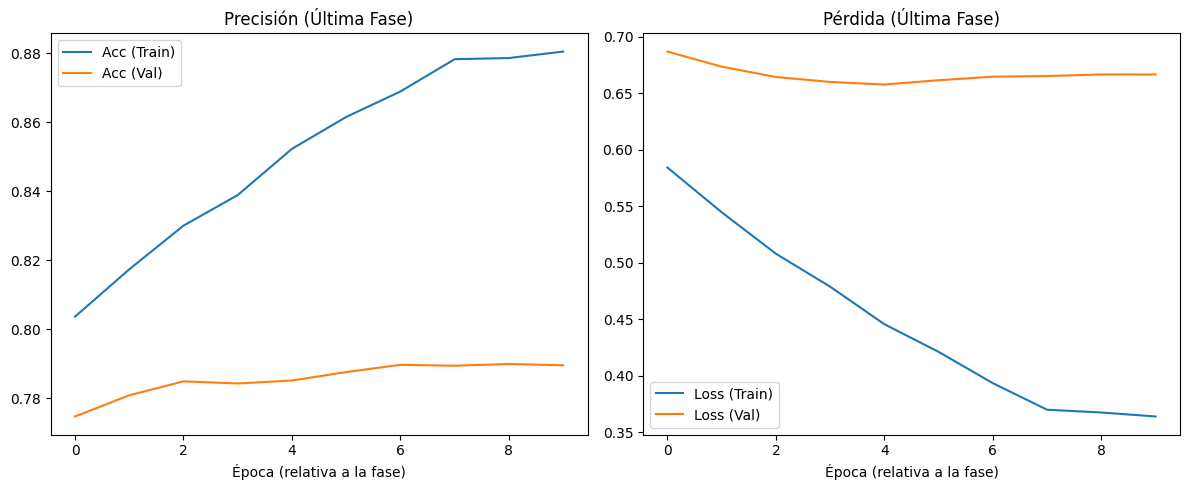

In [29]:
# 15. Visualizar el historial de entrenamiento (Fase 2 o combinado)
print("\nGraficando historial...")
final_history = None
if history_fase2:
    print("Mostrando historial de FASE 2.")
    final_history = history_fase2.history
elif history_fase1:
     print("Mostrando historial de FASE 1 (Fase 2 no se ejecutó).")
     final_history = history_fase1.history

if final_history:
    plt.figure(figsize=(12, 5))
    # Precisión
    plt.subplot(1, 2, 1)
    if 'accuracy' in final_history: plt.plot(final_history['accuracy'], label='Acc (Train)')
    if 'val_accuracy' in final_history: plt.plot(final_history['val_accuracy'], label='Acc (Val)')
    plt.title('Precisión (Última Fase)'); plt.xlabel('Época (relativa a la fase)'); plt.legend()
    # Pérdida
    plt.subplot(1, 2, 2)
    if 'loss' in final_history: plt.plot(final_history['loss'], label='Loss (Train)')
    if 'val_loss' in final_history: plt.plot(final_history['val_loss'], label='Loss (Val)')
    plt.title('Pérdida (Última Fase)'); plt.xlabel('Época (relativa a la fase)'); plt.legend()
    plt.tight_layout(); plt.show()
else:
    print("No hay historial para graficar.")

# Visualizar el Historial de Entrenamiento (Fase 2 o Combinada)

Este bloque de código tiene como objetivo **visualizar el historial de entrenamiento** del modelo, ya sea de la **Fase 1**, la **Fase 2**, o de una combinación de ambas. Dependiendo de si la **Fase 2** se completó o no, se mostrarán las métricas de **precisión** y **pérdida** para las épocas correspondientes.

### Explicación del Código

1. **Definición de la variable `final_history`**:
    - Si el historial de la **Fase 2** (`history_fase2`) existe, se utiliza este historial para graficar.
    - Si **Fase 2** no existe pero **Fase 1** sí, se usa el historial de la **Fase 1**.
    - Si ninguno de los dos historiales está disponible, se imprime un mensaje indicando que no hay historial para graficar.

2. **Creación de la figura de gráficos**:
    - Se usa `plt.figure(figsize=(12, 5))` para definir el tamaño de la figura.

3. **Gráfico de Precisión**:
    - Se grafica la **precisión** (`accuracy` y `val_accuracy`) tanto para el conjunto de **entrenamiento** como para el conjunto de **validación**.
    - En el gráfico, se muestran las métricas de **precisión** por época.
    - Se agregan etiquetas y leyendas para identificar claramente las curvas de **precisión de entrenamiento** y **precisión de validación**.

4. **Gráfico de Pérdida**:
    - De forma similar, se grafica la **pérdida** (`loss` y `val_loss`) para el conjunto de **entrenamiento** y para el conjunto de **validación**.
    - Se agregan etiquetas y leyendas para identificar las curvas de **pérdida de entrenamiento** y **pérdida de validación**.

5. **Ajustes finales y visualización**:
    - Se usa `plt.tight_layout()` para ajustar automáticamente los subgráficos y asegurar que no se solapen.
    - Finalmente, `plt.show()` se utiliza para mostrar los gráficos en el entorno de Colab.

### Resultado Esperado

El resultado final es una visualización con dos gráficos: uno que muestra la **precisión** durante el entrenamiento y otro que muestra la **pérdida**. Ambos gráficos te permitirán evaluar cómo ha mejorado (o empeorado) el modelo durante el entrenamiento en función de las épocas.

- **Precisión**: Compara la precisión obtenida en el conjunto de entrenamiento y validación.
- **Pérdida**: Muestra la evolución de la pérdida en ambos conjuntos, lo que te ayuda a evaluar si el modelo está mejorando o sobreajustando.



Evaluando el MEJOR MODELO FINAL...
Cargando mejor modelo desde: best_model_emociones_emb_fase2.keras

Evaluación (Mejor Modelo): Pérdida=0.6579, Precisión=0.7852
255/255 ━━━━━━━━━━━━━━━━━━━━ 15s 56ms/step

Informe de Clasificación:
                precision    recall  f1-score   support

          asco       0.45      0.52      0.48       458
     decepción       0.52      0.68      0.59       953
     deprimido       0.90      0.90      0.90      1190
desesperanzado       0.90      0.82      0.86       236
         duelo       0.50      0.14      0.22        58
         enojo       0.62      0.62      0.62       277
         miedo       0.55      0.52      0.54       447
   nerviosismo       0.57      0.03      0.06       122
       neutral       0.89      0.92      0.90      1399
 remordimiento       0.64      0.51      0.57       191
     solitario       0.95      0.96      0.96      1005
       suicida       0.97      0.96      0.97      1365
      tristeza       0.77      0.66   

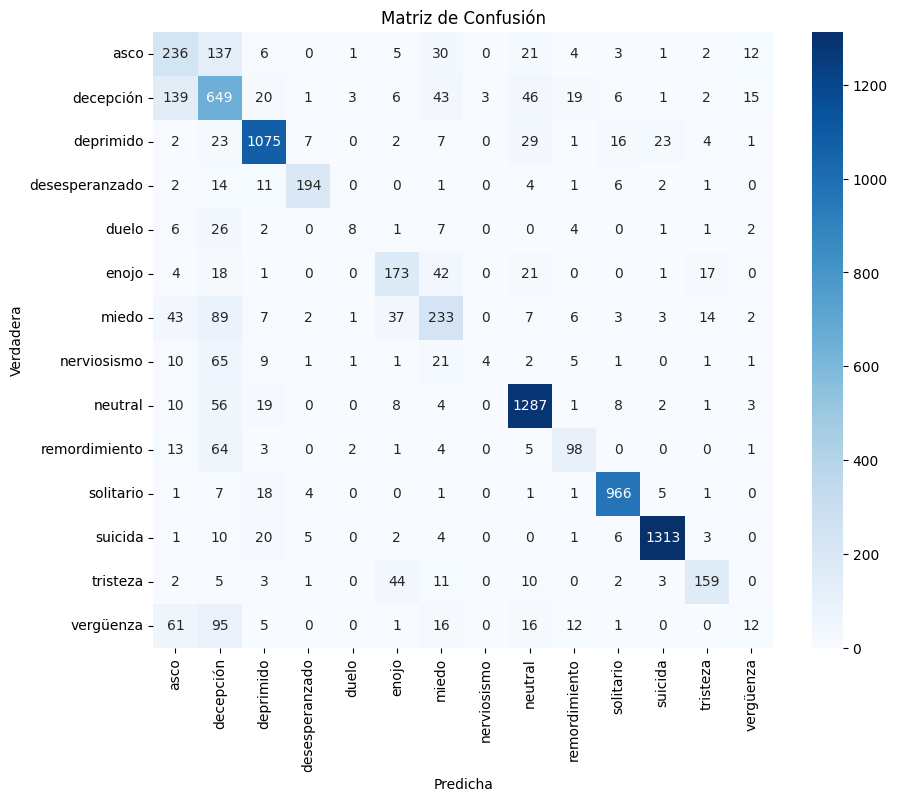

In [30]:
# 16. Evaluar el mejor modelo guardado (Idealmente de Fase 2)
print("\nEvaluando el MEJOR MODELO FINAL...")
# El objeto 'model' debería tener los mejores pesos de Fase 2 si restore_best_weights=True
# O podemos cargar el checkpoint de Fase 2 explícitamente para estar seguros
best_model_path_final = checkpoint_path_fase2 if 'checkpoint_path_fase2' in locals() and os.path.exists(checkpoint_path_fase2) else checkpoint_path_fase1

try:
    print(f"Cargando mejor modelo desde: {best_model_path_final}")
    if os.path.exists(best_model_path_final):
        best_model = load_model(best_model_path_final)
        loss, accuracy = best_model.evaluate(X_val, y_val, verbose=0)
        print(f"\nEvaluación (Mejor Modelo): Pérdida={loss:.4f}, Precisión={accuracy:.4f}")
        y_pred_prob = best_model.predict(X_val); y_pred = np.argmax(y_pred_prob, axis=1)
        y_val_labels = np.argmax(y_val, axis=1)
        print("\nInforme de Clasificación:"); print(classification_report(y_val_labels, y_pred, target_names=label_encoder.classes_, zero_division=0))
        print("\nMatriz de Confusión:"); cm = confusion_matrix(y_val_labels, y_pred)
        plt.figure(figsize=(10, 8)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
        plt.xlabel('Predicha'); plt.ylabel('Verdadera'); plt.title('Matriz de Confusión'); plt.show()
    else:
        print("El archivo del mejor modelo no existe.")
except Exception as e: print(f"\nError evaluando: {e}")

# 17. Función de Predicción y Ejemplos

En esta sección, se define una función para predecir las emociones a partir de un texto utilizando el modelo entrenado previamente. Se procesan las entradas para que sean compatibles con el modelo y luego se devuelve la emoción predicha junto con su probabilidad asociada.

### Explicación del Código

1. **Función de Predicción: `predecir_emocion`**:
   La función `predecir_emocion` toma como entrada un texto y devuelve la emoción predicha por el modelo junto con su probabilidad. Aquí están los pasos que sigue la función:

   - **Validación del texto**: Se verifica que el texto no esté vacío ni sea inválido. Si el texto es inválido, se devuelve un mensaje de error.
   
   - **Limpieza del texto**: El texto es limpiado utilizando la función `clean_text`, que elimina caracteres no deseados, como signos de puntuación, palabras irrelevantes, etc.
   
   - **Tokenización**: El texto limpio es transformado en una secuencia de índices de palabras utilizando el tokenizer previamente entrenado (`tokenizer_func`).
   
   - **Rellenado de la secuencia**: La secuencia de índices de palabras es rellenada para que tenga una longitud consistente (en este caso, `maxlen_func`).
   
   - **Predicción**: Se pasa la secuencia rellena al modelo para obtener las probabilidades de cada emoción. La función `predict` devuelve un vector de probabilidades para cada clase (emoción), y se obtiene la etiqueta con la mayor probabilidad utilizando `np.argmax`.
   
   - **Decodificación de la etiqueta**: Se transforma el índice de la etiqueta predicha de vuelta a su valor original utilizando el `label_encoder_func`.
   
   - **Devolver los resultados**: Finalmente, la función devuelve la emoción predicha junto con su probabilidad.

2. **Prueba de Predicción**:
   Después de definir la función, se realiza una prueba de predicción usando el mejor modelo cargado. Para cada ejemplo de texto, se imprime el texto de entrada, la emoción predicha y la probabilidad asociada.

   - Si el modelo está cargado correctamente (`'best_model'` está definido en el entorno), se prueba con varios textos para ver cómo el modelo predice la emoción.
   
   - Se muestra un ejemplo de predicción para cada uno de los textos proporcionados, incluyendo el texto y la emoción junto con su probabilidad.
   
3. **Condición de Existencia del Modelo**:
   Si no se ha cargado un modelo previamente (si `'best_model'` no está disponible), se muestra un mensaje de error que indica que no se pueden realizar predicciones.



In [31]:
# 17. Función de Predicción y Ejemplos


def predecir_emocion(texto, modelo_pred, tokenizer_func, label_encoder_func, maxlen_func):
  if not texto or not isinstance(texto, str): return "Texto inválido", 0.0
  texto_limpio = clean_text(texto)
  if not texto_limpio: return "Texto vacío después de limpiar", 0.0
  secuencia = tokenizer_func.texts_to_sequences([texto_limpio])
  padded_secuencia = pad_sequences(secuencia, maxlen=maxlen_func, padding='post', truncating='post')
  prediccion_prob = modelo_pred.predict(padded_secuencia)
  etiqueta_idx = np.argmax(prediccion_prob[0])
  probabilidad = np.max(prediccion_prob[0])
  etiqueta_predicha = label_encoder_func.inverse_transform([etiqueta_idx])[0]
  return etiqueta_predicha, probabilidad

if 'best_model' in locals(): # Verificar si se cargó el mejor modelo
    predictor_model = best_model
    print("\nProbando predicción con el mejor modelo cargado:")
    # Ejemplos...
    texto_prueba = "alguna vez se deprimen, porque la única persona con la que quieren hablar y pasar el tiempo está castigada... así que solo están sentados allí, sin hacer nada, porque no tienen ganas de hablar o pasar tiempo con nadie más."
    emocion_predicha, prob = predecir_emocion(texto_prueba, predictor_model, tokenizer, label_encoder, maxlen)
    print(f"Texto: '{texto_prueba}'\nEmoción Predicha: {emocion_predicha} (Probabilidad: {prob:.4f})\n")
    texto_prueba2 = "me siento muy mal, no quiero vivir"
    emocion_predicha2, prob2 = predecir_emocion(texto_prueba2, predictor_model, tokenizer, label_encoder, maxlen)
    print(f"Texto: '{texto_prueba2}'\nEmoción Predicha: {emocion_predicha2} (Probabilidad: {prob2:.4f})\n")
    texto_prueba3 = "Estoy muy feliz con los resultados del examen"
    emocion_predicha3, prob3 = predecir_emocion(texto_prueba3, predictor_model, tokenizer, label_encoder, maxlen)
    print(f"Texto: '{texto_prueba3}'\nEmoción Predicha: {emocion_predicha3} (Probabilidad: {prob3:.4f})\n")
    texto_prueba4 = "El día estuvo normal, nada especial ocurrió, que aburrido."
    emocion_predicha4, prob4 = predecir_emocion(texto_prueba4, predictor_model, tokenizer, label_encoder, maxlen)
    print(f"Texto: '{texto_prueba4}'\nEmoción Predicha: {emocion_predicha4} (Probabilidad: {prob4:.4f})\n")
else:
    print("\nNo se pudo encontrar un modelo ('best_model') para realizar predicciones.")


Probando predicción con el mejor modelo cargado:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step
Texto: 'alguna vez se deprimen, porque la única persona con la que quieren hablar y pasar el tiempo está castigada... así que solo están sentados allí, sin hacer nada, porque no tienen ganas de hablar o pasar tiempo con nadie más.'
Emoción Predicha: deprimido (Probabilidad: 0.9946)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Texto: 'me siento muy mal, no quiero vivir'
Emoción Predicha: deprimido (Probabilidad: 0.9921)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Texto: 'Estoy muy feliz con los resultados del examen'
Emoción Predicha: neutral (Probabilidad: 0.4327)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Texto: 'El día estuvo normal, nada especial ocurrió, que aburrido.'
Emoción Predicha: decepción (Probabilidad: 0.7147)



# 18. Guardar Artefactos Finales

Esta sección del código tiene como objetivo guardar los artefactos finales del modelo, incluyendo el `tokenizer`, el `label_encoder` y los modelos entrenados (Fase 1 y Fase 2). Estos artefactos son necesarios para realizar predicciones con el modelo en el futuro o para reanudar el entrenamiento sin tener que repetir todo el proceso de preprocesamiento y entrenamiento.

### Explicación del Código

1. **Guardar el Tokenizer**:
   El `tokenizer` es un objeto clave que contiene el mapeo de las palabras del conjunto de datos a índices numéricos. Para poder usar el modelo en el futuro, necesitamos guardar el `tokenizer` para que pueda tokenizar nuevas entradas de texto de la misma forma en que lo hizo durante el entrenamiento.
   
   - Se usa la librería `pickle` para guardar el `tokenizer` en un archivo llamado `tokenizer_emociones.pickle`.
   - Si ocurre un error durante el proceso de guardado, se captura la excepción y se imprime un mensaje de error.

2. **Guardar el Label Encoder**:
   El `label_encoder` es otro objeto importante, ya que mapea las etiquetas de las emociones a números y viceversa. Guardar el `label_encoder` es esencial para decodificar las predicciones del modelo de nuevo a sus etiquetas originales.
   
   - Similar al `tokenizer`, el `label_encoder` se guarda utilizando `pickle` en un archivo llamado `label_encoder_emociones.pickle`.
   - Si ocurre un error durante el guardado, también se captura la excepción y se imprime el mensaje de error.

3. **Guardar los Modelos de la Fase 1 y Fase 2**:
   Finalmente, se guarda el modelo entrenado en cada fase. Los modelos de la Fase 1 y Fase 2 pueden ser cargados más tarde para realizar predicciones o continuar el entrenamiento.
   
   - Se guarda el mejor modelo de la Fase 1 con el nombre `checkpoint_path_fase1`.
   - Si existe un modelo de la Fase 2, también se guarda con el nombre `checkpoint_path_fase2`.


In [32]:
  # 18. Guardar artefactos finales

  try:
    with open('tokenizer_emociones.pickle', 'wb') as h: pickle.dump(tokenizer, h, protocol=pickle.HIGHEST_PROTOCOL)
    print("Tokenizer guardado.")
  except Exception as e: print(f"Error guardando tokenizer: {e}")
  try:
    with open('label_encoder_emociones.pickle', 'wb') as h: pickle.dump(label_encoder, h, protocol=pickle.HIGHEST_PROTOCOL)
    print("Label Encoder guardado.")
  except Exception as e: print(f"Error guardando label encoder: {e}")

  print(f"\nMejor modelo Fase 1 guardado como: {checkpoint_path_fase1}")
  if 'checkpoint_path_fase2' in locals(): print(f"Mejor modelo Fase 2 guardado como: {checkpoint_path_fase2}")

Tokenizer guardado.
Label Encoder guardado.

Mejor modelo Fase 1 guardado como: best_model_emociones_emb_fase1.keras
Mejor modelo Fase 2 guardado como: best_model_emociones_emb_fase2.keras
